## NFL Linemen - A Probability Plays Strategy.

#### *For best experience, run entire notebook to hide input cells. To show input cells back, use the menu to clear all outputs.*

#### <font color='289C4E'> Table of Contents.<font><a class='anchor' id='top'></a>
1. [Introduction](#introduction)
2. [The Datasets](#ReadtheDatasets)
3. [The NFL Linemen](#DefinetheNFLLinemen)
4. ['yardsToGo' and 'playResult' Interactive Plot](#AnInteractivePlotof'yardsToGo'and'playResult')
5. [Correlation Between Variables](#EstablishCorrelation)
6. [ 'complete pass' plays - Insights](#Insightsdrawnfromdatasets)
7. [Merger of Datasets](#EstablishtheProjectDataset)
8. [Predict - will a given selection of players and play conditions yield a playResult greater than the NFL average?](#PredictplayResult)
9. [Analysis of play on the NFL pitch](#Analysis)
10. [The ' Probability Strategy ' - What it is](#The'ProbabilityStrategy')
11. [The  ' Probability Strategy '  -  How it Works (Usability) - An Example](#Usability)
12. [Conclusion](#Conclusion)

In [22]:
'''LOAD STANDARD LIBRARIES FOR THE PROCESSING OF DATASETS'''
'''read data'''
import pandas as pd
import numpy as np
from functools import reduce
np.random.seed(42)

'''customed displays of tables'''
from IPython.display import display_html
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
from IPython.display import display_html

'''plots'''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'''preprocess and model the data.'''
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression

'''scoring the model.'''
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error, r2_score

'''plotly for interactive plots'''
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.figure_factory import create_table
import plotly.graph_objs as go

'''garbage cleaning and warnings.'''
import gc
import warnings
warnings.filterwarnings('ignore')

'''create tables'''
! pip install tabulate
from tabulate import tabulate

print('The required system libraries have been loaded into memory' )

<a name="introduction"></a>

### <font color='289C4E'> 1. Introduction.<font><a class='anchor' id='top'></a>

 "This presentation is a submission in the <b>Metric track of the NFL Big Data Bowl 2023 (Help evaluate linemen on pass plays)</b> Kaggle competition in which a plausible play strategy is proposed. The strategy is an application of Statistical theory, Linear Regression and Logistic Regression algorithms on the competition datasets.
 
 "The team averages of 's: Speed in yards/second' and 'dis: Distance traveled from prior time point, in yards' for fielded Linemen form the crux of the proposed strategy. The strategy is adaptable for both right and left flank ('playDirection: Direction that the offense is moving (left or right)') plays.
 
 A thoroughly implemtation of this strategy will ensure that playResult: Net yards gained by the offense, including penalty yardage is sustained at a level higher than the NFL average. From the given datasets, the average NFL playResult for 'complete pass' plays stands at <b>11.681 yards</b>. 
 
 It is a strategy which NFL coaches may wish to integrate into their arsenal. 

<a name="ReadtheDatasets"></a>

### <font color='289C4E'> 2. The Datasets.<font><a class='anchor' id='top'></a>

In [23]:
'''READ THE COMPETITION DATASETS.'''
# games = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/games.csv")
pffScoutingData = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/pffScoutingData.csv")
# players = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/players.csv")
plays = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/plays.csv")
week1 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week1.csv")
week2 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week2.csv")
week3 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week3.csv")
week4 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week4.csv")
week5 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week5.csv")
week6 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week6.csv")
week7 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week7.csv")
week8 = pd.read_csv("C:/Users/Owner/Desktop/nfl-big-data-bowl-2023/nfl-big-data-bowl-2023/week8.csv")

print('only 10 of the 12 csv files of the NFL Big Data Bowl 2023 Kaggle competition data were read to memory.')

only 10 of the 12 csv files of the NFL Big Data Bowl 2023 Kaggle competition data were read to memory.


<b> Overview of the Datasets:</b>
- The <b>play dataframe</b> contains play-level information from each game. The key variables are gameId and playId. A           groupby() resulted in groups,the first of which had a shape of 122 rows × 18 columns.
- The <b>PFF Scouting dataframe</b> contains player-level scouting information for each game and play. The key variables         are gameId, playId, and nflId. With Nan values removed a groupby() resulted in groups, the first of which had a shape       of 8557 rows × 5 columns.
- The <b>week dataframe</b> contains player tracking data from the week. There are 8 such dataframes with an overall             shape of 8314178 rows × 12 columns.

<b> Data processing Steps:</b>
- made sure that all Nan values were removed.
- defined NFL Linemen players.
- compiled the OFFENSIVELINEMEN dataset and presented a view of it's basic statistics.
- chose data for 'complete passes' only and combined the datasets.
- chose data for 'pass forward' events only.
- the approximate probability of occurence of related events were determined. 
- provided a view of the datasets with a focus on the playResult variable.

<a name="DefinetheNFLLinemen"></a>

### <font color='289C4E'> 3. The NFL Linemen.<font><a class='anchor' id='top'></a>
For purposes of this presentation, NFL Offensive Linemen are taken to include the following player positions:
- Right Guard(RG) 
- Right Tackle(RT) 
- Center(C)
- Left Guard(LG)
- Left Tackle(LT)

In [24]:
'''PREPROCESS THE 'pffScoutingData' DATASET.'''
'''define and compile relevant data for the Linemen.'''
'''track pass-block for the QB and run-block for the RB or FB.'''
'''preprocess the 'pffScoutingData'dataset.'''
RG = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='RG']
RT = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='RT']
C =  pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='C']
LT = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='LT']
LG = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='LG']
QB = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='QB']
FB = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='FB']
RB = pffScoutingData.loc[pffScoutingData['pff_positionLinedUp']=='RB']
    
'''merge the various datasets two by two.'''
OffensiveLinemen = pd.concat([RG,RT],ignore_index=True)
OffensiveLinemen1 = pd.concat([OffensiveLinemen,C],ignore_index=True)
OffensiveLinemen2 = pd.concat([OffensiveLinemen1,LT],ignore_index=True)
OffensiveLinemen3 = pd.concat([OffensiveLinemen2,LG],ignore_index=True)

'''remove variables with value = 0.'''
del OffensiveLinemen3['pff_hit']
del OffensiveLinemen3['pff_hurry']
del OffensiveLinemen3['pff_sack']
OFFENSIVELINEMEN = OffensiveLinemen3
   
'''compile relevant data for the QB player.'''
Q_BACK = QB
Q_BACK = Q_BACK.dropna(axis=1) #.describe()
    
'''compile relevant data for the RB and FB players.'''
RB_FB = pd.concat([RB,FB],ignore_index=True)
RB_FB = RB_FB.dropna(axis=1)

'''remove identification and zero value variables'''
#del OFFENSIVELINEMEN['gameId']
#del OFFENSIVELINEMEN['playId']
#del OFFENSIVELINEMEN['nflId']
del OFFENSIVELINEMEN['pff_nflIdBlockedPlayer']
del OFFENSIVELINEMEN['pff_backFieldBlock']

'''construct a mapping using a dictionary and perform a list-comprehension.''' 
col_dict = {'pff_beatenByDefender': 'beatenByDefender', 'pff_hitAllowed': 'hitAllowed',
                'pff_hurryAllowed': 'hurryAllowed',
                'pff_sackAllowed': 'sackAllowed'}

OFFENSIVELINEMEN.columns = [col_dict.get(x, x) for x in OFFENSIVELINEMEN.columns]
OFFENSIVELINEMEN.describe()

'''remove aqll Nan values'''
Dplays = plays.dropna(axis=1) # 122 rows × 18 columns
Dp = Dplays.copy()
'''focus on instances when passResult ends in complete pass(C).'''
DpSC = Dp.loc[Dp['passResult']=='C'] #.value_counts() football    361486
'''remove identification variables'''
del DpSC['gameId']
del DpSC['playId']

'''view statistical details of dataset'''
# DpSC.describe() #print('A table showing Statistical summary of NFL complete_pass plays')

'''apply a user function to rank the 'yardsToGo' value'''
def placement_yardsToGo(x):
    if x <= 8.848:
        return 'below NFL average'
    else:
        return 'above NFL average'

'''apply a user function to rank the playResult scores'''
def placement_playResult(x):
    if x <= 11.681:
        return 'below NFL average'
    else:
        return 'above NFL average'

'''apply the user functions'''  
DplaysC = Dplays.loc[Dplays['passResult']=='C']
DplaysC['yardsToGo_R'] = DplaysC['yardsToGo'].apply(placement_yardsToGo) 
DplaysC['playResult_R'] = DplaysC['playResult'].apply(placement_playResult)


'''choose variables to consider for further analysis'''
PLAY = DplaysC[['gameId','playId','yardsToGo','yardsToGo_R','playResult',
                'playResult_R','pff_passCoverageType']] # 4620 rows × 18 columns

'''probability of occurence of yardsToGo > NFL average'''
P_A = PLAY[PLAY['yardsToGo_R']=='above NFL average'].count() / PLAY['yardsToGo_R'].count()
P_A['yardsToGo_R']

'''probability of occurence of playResult > NFL average'''
P_B = PLAY[PLAY['playResult_R']=='above NFL average'].count() / PLAY['playResult_R'].count()
P_B['playResult_R']

'''probability of occurence of both events
   (yardsToGo > NFL average',playResult > NFL average) 
   occuring'''
P_AandP_B = P_A['yardsToGo_R']*P_B['playResult_R']
P_AandP_B

'''condiional probability playResult|yardsToGo'''
PLAY_Y = PLAY[PLAY['yardsToGo_R']=='above NFL average']
P_B_Y = PLAY_Y[PLAY_Y['playResult_R']=='above NFL average'].count() / PLAY_Y['playResult_R'].count()
P_B_Y['playResult_R']

'''dictionary with list object in values to make into
a dataframe'''
details = {
'Event' : ['yardsToGo', 'playResult', 'yardsToGo_and_playResult', 'playResult_given_yardsToGo'],
'Probability of Occurence of Play Events' : [P_A['yardsToGo_R'], P_B['playResult_R'], P_AandP_B, P_B_Y['playResult_R']],
}

'''view probability table'''
ProbabilityScores = pd.DataFrame(details)
ProbabilityScores.columns.name = 'Probability of Play Events'
display(ProbabilityScores) #print('A table showing the probability scores')
print('')
print('THIS IS THE yardsToGo and playResult PROFILE OF NFL OFFENSIVELINEMEN, QB, FB, RB PLAYERS' )

Probability of Play Events,Event,Probability of Occurence of Play Events
0,yardsToGo,0.631
1,playResult,0.380
2,yardsToGo_and_playResult,0.240
3,playResult_given_yardsToGo,0.402



THIS IS THE yardsToGo and playResult PROFILE OF NFL OFFENSIVELINEMEN, QB, FB, RB PLAYERS


In [25]:
'''what is the mean playResult?'''
ABAB = DplaysC['playResult'].mean()
print("The MEAN of 'playResult' (yards) is: %.2f" % ABAB)

The MEAN of 'playResult' (yards) is: 11.68


<a name="AnInteractivePlotof'yardsToGo'and'playResult'"></a>

### <font color='289C4E'> 4. 'yardsToGo' and 'playResult' Interactive Plot.<font><a class='anchor' id='top'></a>

In [26]:
# x and y given as DataFrame columns
#import plotly.express as px
fig = px.scatter(PLAY, y="playResult", x="yardsToGo", color="playResult_R", symbol="yardsToGo_R")
fig.show()

<b>Plot shows that:</b>
    
- At yardsToGo = 10 yards, the playResult had a range of 116 yards as indicated with a minimum of -25 yards and a maximum of 91 yards. 
    
- At yardsToGo = 8 yards, the playResult had a range of 89 yards as indicated with a minimum of -10 yards and a maximum of 79 yards.

- At yardsToGo = 7 yards, the playResult had a range of 82 yards as indicated with a minimum of -10 yards and a maximum of 72 yards.
    

<a name="EstablishCorrelation"></a>

### <font color='289C4E'> 5. Correlation Between Variables.<font><a class='anchor' id='top'></a>

In [27]:
''' Combine the week datasets.'''
Lweek = [week1,week2,week3,week4,week5,week6,week7,week8]
WEEKS = pd.concat(Lweek)

'''choose variables of interest.'''
WEEKS = WEEKS[['gameId','playId','nflId','playDirection','x','y','s','a','dis',
               'o','dir','event']]

'''choose [WEEKS['event']=='pass_forward']'''
WEEKS = WEEKS.loc[WEEKS['event']=='pass_forward'].reset_index() 

'''view correlation plot'''
WEEKS1=WEEKS.copy()

del WEEKS1['index']
del WEEKS1['gameId']
del WEEKS1['playId']
del WEEKS1['nflId']

df_corr = pd.DataFrame(WEEKS1)
df_corr.columns.name = 'Correlation between numeric variables of the Tracking dataset'
corr = df_corr.corr()
corr.style.background_gradient(cmap='binary').set_precision(2)

Correlation between numeric variables of the Tracking dataset,x,y,s,a,dis,o,dir
Correlation between numeric variables of the Tracking dataset,,,,,,,
x,1.00,-0.00,-0.00,-0.00,-0.01,0.06,-0.17
y,-0.00,1.00,-0.00,-0.00,-0.00,-0.02,0.01
s,-0.00,-0.00,1.00,0.06,0.98,-0.01,0.01
a,-0.00,-0.00,0.06,1.00,0.04,-0.00,-0.00
dis,-0.01,-0.00,0.98,0.04,1.00,-0.01,0.01
o,0.06,-0.02,-0.01,-0.00,-0.01,1.00,0.03
dir,-0.17,0.01,0.01,-0.00,0.01,0.03,1.00


<b>The three most correlated variables include:</b>

<b>x: Player position along the long axis of the field, 0 - 120 yards is positively correlated (0.06) with o: Player orientation (deg), 0 - 360 degrees.</b>
   
<b>s: Speed in yards/second  is positively correlated (0.06) with a: Acceleration in yards/second^2.</b> 
    
<b>s: Speed in yards/second  is positively correlated (0.98) with dis: Distance traveled from prior time point, in yards.</b> 

<a name="Insightsdrawnfromdatasets"></a>

### <font color='289C4E'> 6. 'complete pass' plays - Insights.<font><a class='anchor' id='top'></a>

  - about <b>54%</b> of passResult are expected to end up as complete passes
  - the average ('yardsToGo') distance needed for a first down is <b>8.734 yards</b>. Overall, less than <b>25% of            'yardsToGo' readings are greater than 10 yards</b> while, the maximum is 39 yards.
  - the average NFL playResult for 'complete pass' plays stands at about <b>11.681 yards</b>.
  - More than 75% of <b>'yardsToGo'</b> are less than <b>6 yards</b> while, 75% of <b>'playResult'</b> are <b>zero</b>.
  - <b>The probability of occurrence of 'yardsToGo > NFL average' and 'playResult > NFL average' is given by,    
      P('yardsToGo > NFL average' and 'playResult > NFL average') = 0.6313 · 0.4018 = 0.2536</b>.   
      
  - 92.88% of pass block instances is attributable to linemen players.
  - 99.98% of passes were attributed to offensive linemen.
  - if 'None' category is excluded then, 'pass_forward' events constitute about <b>27%</b> of all play events.
  - if 'None' category is included then, 'pass_forward' events constitute about <b>2%</b> of all play.
  - correlation between s: Speed in yards/second and dis: Distance traveled from prior time point, in yards stands at 0.98

<a name="EstablishtheProjectDataset"></a>

### <font color='289C4E'> 7. Merger of Datasets.<font><a class='anchor' id='top'></a>

In [28]:
''' merge OFFENSIVELINEMEN, PLAY, WEEKS datasets.'''
PROJECTDATA = pd.merge(PLAY, WEEKS, on=['gameId','playId'])#,'nflId']) # 418 rows × 13 columns
PROJECTDATA = pd.merge(PROJECTDATA, OFFENSIVELINEMEN, on=['gameId','playId']) # 192 rows × 16 columns

PROJECTDATA['ttt'] = 120 - PROJECTDATA['x'] 
PROJECTDATA['ttt'] = PROJECTDATA['ttt'] / PROJECTDATA['s'].round(2)
del PROJECTDATA['gameId']
del PROJECTDATA['playId']
del PROJECTDATA['index']
del PROJECTDATA['nflId_x']
del PROJECTDATA['nflId_y']

print('A VIEW OF THE FIRST ROW OF THE MERGED DATASET FOR FURTHER ANALYSIS')
PROJECTDATA[:1] #, PROJECTDATA.shape # (530242, 22)

A VIEW OF THE FIRST ROW OF THE MERGED DATASET FOR FURTHER ANALYSIS


,yardsToGo,yardsToGo_R,playResult,playResult_R,pff_passCoverageType,playDirection,x,y,s,a,dis,o,dir,event,pff_role,pff_positionLinedUp,beatenByDefender,hitAllowed,hurryAllowed,sackAllowed,pff_blockType,ttt
0,10,above NFL average,28,above NFL average,Zone,left,112.85,23.58,1.05,1.52,0.1,102.9,63.61,pass_forward,Pass Block,RG,0.0,0.0,0.0,0.0,PP,6.81


   - merged WEEKS , PLAY and OFFENSIVELINEMEN datasets. 
   - chose data for pass forward events only : [WEEKS['event']=='pass_forward']
   - the probability of occurence of this event is approximated 
   - provided a view of the datasets with a focus on the playResult variable.
   - the playResult, is taken to be an adequate measure of the successful outcome of a given play.

<a name="PredictplayResult"></a>

### <font color='289C4E'> 8. Predict - will a given selection of players and play conditions yield a playResult greater than the NFL average?:-<font><a class='anchor' id='top'></a>

In [29]:
PROJECTDATA_PROBA = pd.get_dummies(PROJECTDATA[['yardsToGo_R','pff_positionLinedUp', 'playResult_R','pff_passCoverageType','playDirection']],drop_first=True)
PROJECTDATA_PROBA[:5]

'''feature engineering (one hot encoding)''' 
# np.random.seed(42)

#PROJECTDATA_RGRC = PROJECTDATA_RGR[['yardsToGo_R','pff_positionLinedUp', 'playResult_R','pff_passCoverageType']]


#PROJECTDATA_RGRC = pd.get_dummies(PROJECTDATA_RGRC[['yardsToGo_R','pff_positionLinedUp', 'playResult_R','pff_passCoverageType']],drop_first=False)
#PROJECTDATA_RGRC.sample(5)

X1 = PROJECTDATA_PROBA[['yardsToGo_R_below NFL average','pff_positionLinedUp_LG','pff_positionLinedUp_LT',
                    'pff_positionLinedUp_RG', 'pff_positionLinedUp_RT', 
                    'pff_passCoverageType_Other','pff_passCoverageType_Zone','playDirection_right']] # 'playResult_R_above NFL average',

y1 = PROJECTDATA_PROBA['playResult_R_below NFL average']

'''test train split'''
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.1, random_state=42)

''' train the model using training data'''
LogReg1 = LogisticRegression() #(solver='lbfgs')

print('The model has been trained successfully')


The model has been trained successfully


In [30]:
'''given this combination ( see below) of players 
on the field of play predict whether or not 
playResult is (below average =0 OR above average = 1): '''

LogReg1.fit(X1_train, y1_train)

# yardsToGo_R_below NFL average(1)
# pff_positionLinedUp_LG(1)
# pff_positionLinedUp_LT(1)
# pff_positionLinedUp_RG(1)
# pff_positionLinedUp_RT(1)
# pff_passCoverageType_Other(0)
# pff_passCoverageType_Zone(1)
# playDirection_right(1)

AAA = LogReg1.predict(np.array([[1,1,1,1,1,0,1,1]]))[0]
print("THE PREDICTION, FOR THE CHOSEN GROUP OF LINEMEN PLAYERS is(1 for above average; 0 for below average): %.2f" % AAA) 

THE PREDICTION, FOR THE CHOSEN GROUP OF LINEMEN PLAYERS is(1 for above average; 0 for below average): 1.00


In [31]:
'''# scoring the model'''
BBB = LogReg1.score(X1_test,y1_test)
print("The PREDICTION SCORE of the model is: %.2f" % BBB)#: %.2f" % r2_score(y_RGR_test, y_RGR_pred))

The PREDICTION SCORE of the model is: 0.62


[[ 2.94522207e-01  4.50773779e-03  1.40170210e-03 -1.34245436e-03
  -2.11986765e-03  1.62403098e+00  4.88915944e-01  3.24042599e-02]]


[Text(0.5, 1.0, 'coefficients of the 8 predictors of playResult')]

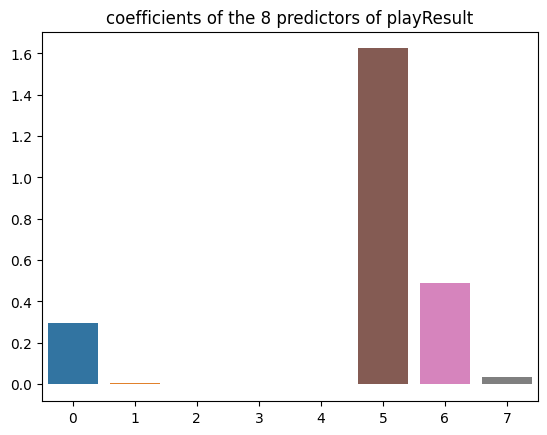

In [32]:
'''# The estimated coefficients will all be around 1:'''
print(LogReg1.coef_)

dfFI=pd.DataFrame(LogReg1.coef_)
data=dfFI
sns.barplot(data).set(title='coefficients of the 8 predictors of playResult')

For the given group of Linemen, the 4 noticeable and influential determinants of playResult are <b>'pff_passCoverageType_Other', 'pff_passCoverageType_Zone', 'yardsToGo_R_below NFL average' and 'playDirection_right'</b> respectively.

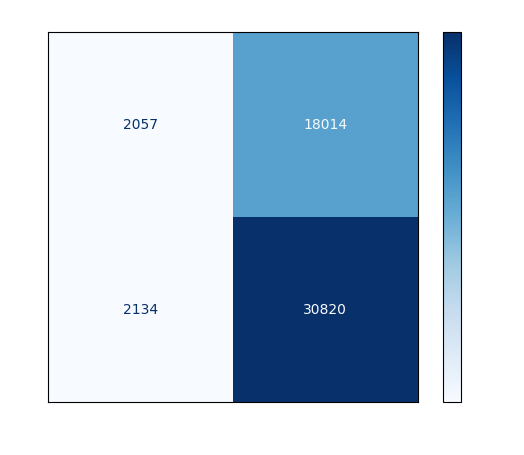

In [33]:
'''# Run the confusion matrix function on actual and predicted values'''
y1_pred=LogReg1.predict(X1_test)

cm1 = confusion_matrix(y1_test, y1_pred)

'''# Plot the confusion matrix
#import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix'''
color = 'white'
matrix = plot_confusion_matrix(LogReg1, X1_test, y1_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
#plt.title('Confusion Matrix')
plt.show()

# Top left quadrant = True Positives = Number of benign labelled as benign (true positive = TP)
# Bottom right quadrant = True Negatives = Number of malignant labelled as malignant (true negative = TN)
# Top right quadrant = False Positives = Number of benign labelled as malignant (false positives = FP)
# Bottom left quadrant = False Negatives = Number of malignant labelled as benign# (false negatives = FN) # # 

In [34]:
'''# Run the classification report
# With data from the confusion matrix, you can interpret the results by looking at the classification report.'''

print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.49      0.10      0.17     20071
           1       0.63      0.94      0.75     32954

    accuracy                           0.62     53025
   macro avg       0.56      0.52      0.46     53025
weighted avg       0.58      0.62      0.53     53025



In [35]:
CCC = precision_score(y1_test, y1_pred, average='weighted')
print("The PRECISION SCORE of the model is: %.2f" % CCC)#: %.2f" % r2_score(y_RGR_test, y_RGR_pred))

The PRECISION SCORE of the model is: 0.58


<a name="Analysis"></a>

### <font color='289C4E'> 9. Analysis of play on the NFL pitch.<font><a class='anchor' id='top'></a>

<b>The analysis covers the following 4 play scenarios:</b>

<b>SCENARIO D1:</b>
<b>- 'playResult' is greater than the NFL average and the 'playDirection' is 'right' with focus on 'dis': Distance traveled from prior time point, in yards.</b><font><a class='anchor' id='top'></a>

In [36]:
PROJECTDATA_RGR = PROJECTDATA.loc[(PROJECTDATA['playResult_R']=='above NFL average') & (PROJECTDATA['playDirection']=='right')]

PROJECTDATA_RGR = PROJECTDATA_RGR[['yardsToGo', 'yardsToGo_R', 'playResult', 'playResult_R',
                                   'x', 'y', 's', 'a', 'dis', 'o', 'ttt', 'dir','pff_positionLinedUp','pff_passCoverageType']]

'''First replace() inf and -inf with nan:'''
PROJECTDATA_RGR = PROJECTDATA_RGR.replace([np.inf, -np.inf], np.nan)

'''remove aqll Nan values'''
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
PROJECTDATA_RGR.ttt = imputer.fit_transform(PROJECTDATA_RGR['ttt'].values.reshape(-1,1))[:,0]

'''display statistics of dataset'''
#PROJECTDATA_RGR.columns.name = 'STATISTICS FOR playResult_R == above NFL average &  playDirection == right'
#display(PROJECTDATA_RGR.describe())

np.random.seed(42)

#initiate linear regression model
model_RGR = LinearRegression()

#define predictor and response variables
y_RGR = PROJECTDATA_RGR['dis']
X_RGR = PROJECTDATA_RGR[['x', 'y' , 's' , 'yardsToGo','ttt']]

#X, y = df[['x1', 'x2']], df.y

#fit regression model
model_RGR.fit(X_RGR, y_RGR)

#display regression coefficients and R-squared value of model
print("SCENARIO D1 model intercept : %.2f" % model_RGR.intercept_)
print('')
print(model_RGR.coef_)
print('')
print("SCENARIO D1 model score: %.2f" % model_RGR.score(X_RGR, y_RGR))#: %.2f" % r2_score(y_RGR_test, y_RGR_pred))

'''Use average values of predictors to preview general effect'''
# x: Player position along the long axis of the field, 0 - 120 yards
x_RGR = PROJECTDATA_RGR['x'].mean().round(3)

# y: Player position along the short axis of the field, 0 - 53.3 yards.
y_RGR = PROJECTDATA_RGR['y'].mean().round(3)

# s: Speed in yards/second
s_RGR = PROJECTDATA_RGR['s'].mean().round(3)

# yardsToGo: Distance needed for a first down 
yardsToGo_RGR = PROJECTDATA_RGR['yardsToGo'].mean().round(3)

ttt_RGR = PROJECTDATA_RGR['ttt'].mean().round(3)

dis_RGR = -0.01 - 1.96998573e-04 * x_RGR - 2.70871293e-05 * y_RGR + 1.06357404e-01 * s_RGR - 1.09909224e-04 * yardsToGo_RGR +  2.90585553e-05 * ttt_RGR
print('')
print('')
print("using mean values, if playResult > NFL average and playdirection = right then, dis: must be at least: \n", dis_RGR)

SCENARIO D1 model intercept : -0.01

[-1.96998573e-04 -2.70871293e-05  1.06357404e-01 -1.09909224e-04
  2.90585553e-05]

SCENARIO D1 model score: 0.96


using mean values, if playResult > NFL average and playdirection = right then, dis: must be at least: 
 0.36242872068942494


<b>SCENARIO D2:</b>
<b>- 'playResult' is greater than the NFL average and the 'playDirection' is 'left' with focus on 'dis': Distance traveled from prior time point, in yards.</b><font><a class='anchor' id='top'></a>

In [37]:
PROJECTDATA_LGR = PROJECTDATA.loc[(PROJECTDATA['playResult_R']=='above NFL average') & (PROJECTDATA['playDirection']=='left')]
'''First replace() inf and -inf with nan:'''
PROJECTDATA_LGR = PROJECTDATA_LGR.replace([np.inf, -np.inf], np.nan)
'''remove aqll Nan values'''
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
PROJECTDATA_LGR.ttt = imputer.fit_transform(PROJECTDATA_LGR['ttt'].values.reshape(-1,1))[:,0]

#PROJECTDATA_LGR.columns.name = 'STATISTICS FOR playResult_R == above NFL average &  playDirection == left'
#display(PROJECTDATA_LGR.describe())

del PROJECTDATA_LGR['sackAllowed']

np.random.seed(42)

#initiate linear regression model
model_LGR = LinearRegression()

#define predictor and response variables
y_LGR = PROJECTDATA_RGR['dis']
X_LGR = PROJECTDATA_RGR[['x', 'y' , 's' , 'yardsToGo','ttt']]

#X, y = df[['x1', 'x2']], df.y

#fit regression model
model_LGR.fit(X_LGR, y_LGR)


'''Use average values of predictors to preview general effect'''
# x: Player position along the long axis of the field, 0 - 120 yards
x_LGR = PROJECTDATA_LGR['x'].mean().round(3)

# y: Player position along the short axis of the field, 0 - 53.3 yards.
y_LGR = PROJECTDATA_LGR['y'].mean().round(3)

# s: Speed in yards/second
s_LGR = PROJECTDATA_LGR['s'].mean().round(3)

# yardsToGo: Distance needed for a first down 
yardsToGo_LGR = PROJECTDATA_LGR['yardsToGo'].mean().round(3)

ttt_LGR = PROJECTDATA_LGR['ttt'].mean().round(3)

'''#display regression coefficients and R-squared value of model'''
print("SCENARIO D2 model intercept : %.2f" % model_LGR.intercept_)
print('')
print(model_LGR.coef_)
print('')
#print(model_LGR.score(X_LGR, y_LGR)) #: %.2f" % r2_score(y_RGR_test, y_RGR_pred))
#print("SCENARIO 2 model score: %.2f" % model_LGR.score(X_LGR, y_LGR))#: %.2f" % r2_score(y_RGR_test, y_RGR_pred))

dis_LGR = -0.01 -1.96998573e-04 * x_LGR - 2.70871293e-05 * y_LGR + 1.06357404e-01 * s_LGR - 1.09909224e-04 * yardsToGo_LGR +  2.90585553e-05 * ttt_LGR
print('')
print('')
print("using mean values, if playResult > NFL average and playdirection = left then, dis: must be at least: \n", dis_LGR)

SCENARIO D2 model intercept : -0.01

[-1.96998573e-04 -2.70871293e-05  1.06357404e-01 -1.09909224e-04
  2.90585553e-05]



using mean values, if playResult > NFL average and playdirection = left then, dis: must be at least: 
 0.35706575871190255


<b>SCENARIO S1:</b>
<b>- 'playResult' is greater than the NFL average and the 'playDirection' is 'right' with focus on 's': Speed in yards/second.</b><font><a class='anchor' id='top'></a>

In [38]:
np.random.seed(42)

#initiate linear regression model
model_RGRs = LinearRegression()

#define predictor and response variables
y_RGRs = PROJECTDATA_RGR['s']
X_RGRs = PROJECTDATA_RGR[['x', 'y' , 'dis' , 'yardsToGo','ttt']]

#X, y = df[['x1', 'x2']], df.y

#fit regression model
model_RGRs.fit(X_RGRs, y_RGRs)
'''Use average values of predictors to preview general effect'''
# x: Player position along the long axis of the field, 0 - 120 yards
x_RGRs = PROJECTDATA_RGR['x'].mean().round(3)

# y: Player position along the short axis of the field, 0 - 53.3 yards.
y_RGRs = PROJECTDATA_RGR['y'].mean().round(3)

# s: Speed in yards/second
dis_RGRs = PROJECTDATA_RGR['dis'].mean().round(3)

# yardsToGo: Distance needed for a first down 
yardsToGo_RGRs = PROJECTDATA_RGR['yardsToGo'].mean().round(3)

ttt_RGRs = PROJECTDATA_RGR['ttt'].mean().round(3)

'''#display regression coefficients and R-squared value of model'''
print("SCENARIO S1 model intercept : %.2f" % model_RGRs.intercept_)
print('')
print(model_RGRs.coef_)
print('')
#print(model_RGRs.score(X_RGRs, y_RGRs)) #: %.2f" % r2_score(y_RGR_test, y_RGR_pred))
s_RGRs = 0.20 + 2.55638093e-03 * x_RGRs + 9.65699412e-05 * y_RGRs + 8.96672726e+00 * dis_RGRs + 8.99293445e-04 * yardsToGo_RGRs - 5.43712381e-04 * ttt_RGRs
print('')
print('')
print("using mean values, if playResult > NFL average and playdirection = right then, s: must be at least: \n", s_RGRs)

SCENARIO S1 model intercept : 0.20

[ 2.55638093e-03  9.65699412e-05  8.96672726e+00  8.99293445e-04
 -5.43712381e-04]



using mean values, if playResult > NFL average and playdirection = right then, s: must be at least: 
 3.6135177371892175


<b>SCENARIO S2:</b>
<b>- 'playResult' is greater than the NFL average and the 'playDirection' is 'left' with focus on s: Speed in yards/second.</b><font><a class='anchor' id='top'></a>

In [39]:
np.random.seed(42)

#initiate linear regression model
model_LGRs = LinearRegression()

#define predictor and response variables
y_LGRs = PROJECTDATA_RGR['s']
X_LGRs = PROJECTDATA_RGR[['x', 'y' , 'dis' , 'yardsToGo','ttt']]

#X, y = df[['x1', 'x2']], df.y

#fit regression model
model_LGRs.fit(X_LGRs, y_LGRs)


'''Use average values of predictors to preview general effect'''
# x: Player position along the long axis of the field, 0 - 120 yards
x_LGRs = PROJECTDATA_LGR['x'].mean().round(3)

# y: Player position along the short axis of the field, 0 - 53.3 yards.
y_LGRs = PROJECTDATA_LGR['y'].mean().round(3)

# s: Speed in yards/second
dis_LGRs = PROJECTDATA_LGR['dis'].mean().round(3)

# yardsToGo: Distance needed for a first down 
yardsToGo_LGRs = PROJECTDATA_LGR['yardsToGo'].mean().round(3)

ttt_LGRs = PROJECTDATA_LGR['ttt'].mean().round(3)

'''#display regression coefficients and R-squared value of model'''
print("SCENARIO S2 model intercept : %.2f" % model_LGR.intercept_)
print('')
print(model_LGRs.coef_)
print('')
#print(model_LGR.score(X_LGR, y_LGR)) #: %.2f" % r2_score(y_RGR_test, y_RGR_pred))
#print("SCENARIO 2 model score: %.2f" % model_LGR.score(X_LGR, y_LGR))#: %.2f" % r2_score(y_RGR_test, y_RGR_pred))

s_LGRs = -0.01 + 2.55638093e-03 * x_LGRs + 9.65699412e-05 * y_LGRs + 8.96672726e+00 * dis_LGRs + 8.99293445e-04 * yardsToGo_LGRs - 5.43712381e-04 * ttt_LGRs
print('')
print('')
print("using mean values, if playResult > NFL average and playdirection = left then, s: must be at least: \n", s_LGRs)

SCENARIO S2 model intercept : -0.01

[ 2.55638093e-03  9.65699412e-05  8.96672726e+00  8.99293445e-04
 -5.43712381e-04]



using mean values, if playResult > NFL average and playdirection = left then, s: must be at least: 
 3.390125814464338


In [40]:
summaryD = {
      'SCENARIOS':['playResult > NFLaverage;playDirection is right',
                   'playResult > NFLaverage;playDirection is left '],
      'dis_model_intercept':[-0.01,-0.01],
      
      'dis_mean(in yards)':[0.3624,0.3570]
      
}

# creating a Dataframe object 
SUMMARYD = pd.DataFrame(summaryD)
SUMMARYD.columns.name = 'D1 and D2 (dis) SCENARIOS '  
display(SUMMARYD)
print('this result suggests that given dis: (Distance traveled from prior time point, in yards), it is reasonable to assume that on the average playResult: (Net yards gained by the offense, including penalty yardage) will yield a higher value when playDirection is right than it does when playDirection is left')

D1 and D2 (dis) SCENARIOS,SCENARIOS,dis_model_intercept,dis_mean(in yards)
0,playResult > NFLaverage;playDirection is right,-0.01,0.362
1,playResult > NFLaverage;playDirection is left,-0.01,0.357


this result suggests that given dis: (Distance traveled from prior time point, in yards), it is reasonable to assume that on the average playResult: (Net yards gained by the offense, including penalty yardage) will yield a higher value when playDirection is right than it does when playDirection is left


In [41]:
summaryS = {
      'SCENARIOS':['playResult > NFLaverage;playDirection is right',
                   'playResult > NFLaverage;playDirection is left '],
                  
      's_model_intercept':[0.20,-0.01],
      
      's_mean(in yards/second)':[3.613,3.39]
      
}

# creating a Dataframe object 
SUMMARYS = pd.DataFrame(summaryS)
SUMMARYS.columns.name = 'S1 and S2 (s) SCENARIOS '   
display(SUMMARYS)
print('this result suggests that given s: (Speed in yards/second), it is reasonable to assume that on the average playResult: (Net yards gained by the offense, including penalty yardage) will yield a higher value when playDirection is right than it does when playDirection is left')

S1 and S2 (s) SCENARIOS,SCENARIOS,s_model_intercept,s_mean(in yards/second)
0,playResult > NFLaverage;playDirection is right,0.20,3.613
1,playResult > NFLaverage;playDirection is left,-0.01,3.390


this result suggests that given s: (Speed in yards/second), it is reasonable to assume that on the average playResult: (Net yards gained by the offense, including penalty yardage) will yield a higher value when playDirection is right than it does when playDirection is left


<b>Subsequently, it is reasonable to assume that play in the right hand flank (playDirection: Direction that the offense  moving is right) produces higher playResult than, when play is in the left hand flank (playDirection: Direction that the offense is moving is left)</b>

<a name="The'ProbabilityStrategy'"></a>

### <font color='289C4E'> 10. The  ' Probability Strategy '  -  What it is.<font><a class='anchor' id='top'></a>

- The objective is to improve and focus performance of the Linemen at ensuring that, the 'playresult' is sustained at a level greater than the NFL national average at each play.
- The 'Probability Strategy' is based on the probabilities of occurence of yardsToGo and favourable events during NFL plays and it is best suited for complete forward_pass situations . 
- If determinant factors including the knowledge of the opposing team, ability of Linemen players, the play environment are considered then, the versatility of this strategy could be exploited fully. 

<a name="Usability"></a>

### <font color='289C4E'> 11. The  ' Probability Strategy '  -  How it Works (Usability) - An Example.<font><a class='anchor' id='top'></a>

- Paragraph 8 details the prediction of the combination of Linemen that will sustain the playResult at levels     higher than the NFL average.   
- Paragraph 9 details the prediction of the value of playResult: Net yards gained by the offense, including penalty yardage. The value of playResult is a factor of many determinant variables. For purposes of this example, only scenarios D1 and S1 are examined.

In [42]:
'''
based on the results in paragraph 8 above, take a sample of 4 to represent

pff_positionLinedUp_LG(1)
pff_positionLinedUp_LT(1)
pff_positionLinedUp_RG(1)
pff_positionLinedUp_RT(1)

from data used in scenario D1
'''
s_sample = PROJECTDATA_RGR['s'].sample(4)
dis_sample = PROJECTDATA_RGR['dis'].sample(4)

'''define approximate probabilities of playDirection'''
PROJECTDATA['playDirection'].value_counts() #left     274482  right    255760
RIGHT = 255760 / 530242
LEFT = 274482 / 530242

'''view emerged details'''
#print("sample of dis: for 4 Linemen players: \n", dis_sample) # 484948    0.55, 309833    0.51, 383252    0.14, 89498     0.84
#print('')
#print("sample of s: for 4 Linemen players: \n", s_sample) # 57855     2.54, 316130    4.07, 16465     1.65, 24525     2.89 
#print('')
print("proportion ( approximate probability ) of playDirection = right is: \n", RIGHT)
print('')
print("proportion ( approximate probability ) of playDirection = left is: \n", LEFT)

proportion ( approximate probability ) of playDirection = right is: 
 0.482345796824846

proportion ( approximate probability ) of playDirection = left is: 
 0.517654203175154


' The expected value <b>E(x)</b> is given by:

 <font size="+2">E ( x ) = ∑ x * P ( x ).</font>
 
 -------
 
 <b> for variable (dis), the expected value E(dis) = </b> 0.15*0.48 + 0.36*0.48 + 0.07*0.48 + 0.61*0.48 = <b>0.57</b> 
 
 this is greater than <b>0.362</b> which is the least 'dis' value required as indicated in; playResult > NFLaverage;playDirection is right, scenario D1 above. 
 
 -------

<b> for variable (s), the expected value E(s) = </b> 2.10*0.52 + 2.79*0.52 + 2.80*0.52 + 5.06*0.52 = <b>6.63</b> 
 
 this is greater than <b>3.613</b> which is the least 's' value required as indicated in, playResult > NFLaverage;playDirection is right, scenario S1 above. 

<a name="Conclusion"></a>

### <font color='289C4E'> 12. Conclusion.<font><a class='anchor' id='top'></a>
   The 'Probability Strategy' embraces probabilities which could be exploited to enhance NFL team game plays performance and productivity. 
    
   The strategy establishes an expectation whereby the gain in yards greater than the NFL average <b> E(X) > 11.681 </b> is assured.
    
   Thus, given that play conditions are favourable and constant the knowledge of what combination of Linemen players to have on the field for a specific play can be put to excellent use. 
    
   The assumptions and models used in this presentation could be improved upon. Hopefully, as experience using the strategy grows NFL teams will benefit greatly.   

In [ ]:
%%html
<style>
div.input {
    display:none;
}
</style>